# Домашнее задание № 9

### Задание 1 (5 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs.ipynb

Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую.
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [8]:
pip install scikit-learn pandas matplotlib accelerate transformers keras -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 801.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.1.1


In [2]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


In [ ]:
data.topic.value_counts()

topic
Из жизни             55
Бывший СССР          54
Наука и техника      54
Культура             53
Ценности             45
Дом                  45
Интернет и СМИ       44
Бизнес               44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: count, dtype: int64

### Дообучение с замораживанием предобученной модели bert-base-multilingual-cased

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = BertModel.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

NameError: name 'tokenizer' is not defined

In [ ]:
for param in model_bert.parameters():
    param.requires_grad = False

class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")


output = bert_wrapper(model_bert)(input_word_ids)
# добавим дропаут чтобы не переобучалось
drop = keras.layers.Dropout(0.1)(output[:, 0]) # [0][:, 0] - означает что мы берем первое
                                                     # состояние у всех текстов в батче
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

# обычно при дообучении трансформеров нужно ставить очень маленький лосс
# но когда мы обучаем только итоговый классификатор то можно ставить побольше
model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_wrapper_1 (bert_wrapper)        │ (None, 512, 768)            │     177,853,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │          13,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,866,513 (678.51 MB)

 Trainable params: 13,073 (51.07 KB)

 Non-trainable params: 177,853,440 (678.46 MB)

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [ ]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=20,
          epochs=20)

Epoch 1/20


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 620ms/step - accuracy: 0.0916 - loss: 2.9015 - rec_prec: 0.0036 - val_accuracy: 0.0968 - val_loss: 2.7285 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 630ms/step - accuracy: 0.0878 - loss: 2.7384 - rec_prec: 3.9352e-04 - val_accuracy: 0.0968 - val_loss: 2.7140 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 625ms/step - accuracy: 0.1027 - loss: 2.6825 - rec_prec: 4.6483e-04 - val_accuracy: 0.0968 - val_loss: 2.7028 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step - accuracy: 0.1274 - loss: 2.6468 - rec_prec: 0.0023 - val_accuracy: 0.0968 - val_loss: 2.7209 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 627ms/step - accuracy: 0.1405 - loss: 2.6459 - rec_prec: 0.0023 - val_accuracy: 0.1290 - val_loss: 2.6897 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 633ms/step - accuracy: 0.1488 - loss: 2.6235 - rec_prec: 0.0069 - val_accuracy: 0.0968

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


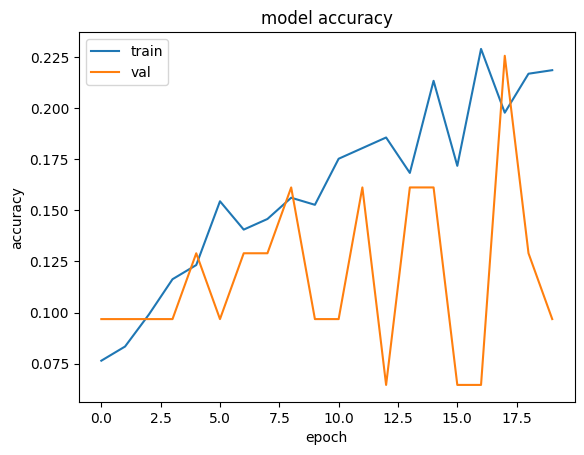

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
                   precision    recall  f1-score   support

  Наука и техника       0.12      0.67      0.20         3
           Россия       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
       Библиотека       0.00      0.00      0.00         0
      Бывший СССР       0.00      0.00      0.00         3
         Культура       0.00      0.00      0.00         3
            Спорт       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
         Из жизни       0.00      0.00      0.00         3
              Дом       0.00      0.00      0.00         2
         Ценности       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
        Экономик

### Дообучение без замораживания Twitter/twhin-bert-base

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')
model_bert = AutoModel.from_pretrained('Twitter/twhin-bert-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [ ]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=15)

Epoch 1/15


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_1', 'variable_209', 'variable_210'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 76s 526ms/step - accuracy: 0.0715 - loss: 2.9040 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7827 - val_rec_prec: 0.0000e+00
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 78s 540ms/step - accuracy: 0.0792 - loss: 2.7647 - rec_prec: 0.0017 - val_accuracy: 0.0968 - val_loss: 2.7280 - val_rec_prec: 0.0000e+00
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 545ms/step - accuracy: 0.0869 - loss: 2.7632 - rec_prec: 0.0028 - val_accuracy: 0.0968 - val_loss: 2.7081 - val_rec_prec: 0.0000e+00
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 548ms/step - accuracy: 0.0752 - loss: 2.8603 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7502 - val_rec_prec: 0.0000e+00
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 549ms/step - accuracy: 0.0838 - loss: 2.8050 - rec_prec: 2.4631e-04 - val_accuracy: 0.0645 - val_loss: 2.7248 - val_rec_prec: 0.0000e+00
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 549ms/step - accuracy: 0.0884 - loss: 2.7868 - rec_prec: 0.0000e+00 - 

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


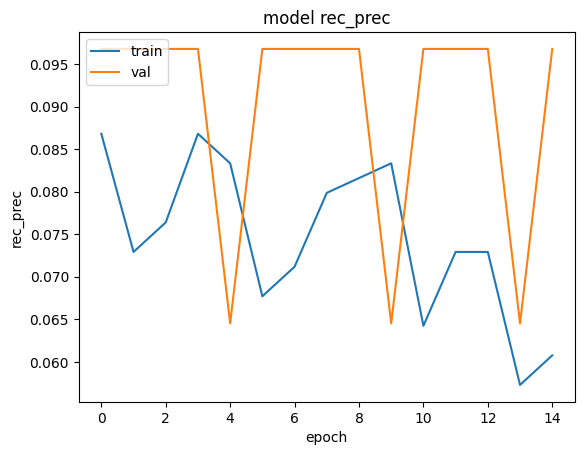

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
                   precision    recall  f1-score   support

            Спорт       1.00      0.50      0.67         2
      Бывший СССР       0.33      0.33      0.33         3
              Дом       0.00      0.00      0.00         2
         Культура       0.00      0.00      0.00         3
         Из жизни       0.14      0.33      0.20         3
         Ценности       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
  Наука и техника       0.00      0.00      0.00         3
             Крым       0.00      0.00      0.00         0
   69-я параллель       0.00      0.00      0.00         1
        Экономика       0.25      0.50      0.33         2
           Россия       0.00      0.00      0.00         2
           Бизне

### Дообучение без замораживания Twitter/twhin-bert-large

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model_bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [ ]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=15)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_408', 'variable_409'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 428ms/step - accuracy: 0.0685 - loss: 3.0294 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7359 - val_rec_prec: 0.0000e+00
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 435ms/step - accuracy: 0.0898 - loss: 2.7877 - rec_prec: 8.3790e-04 - val_accuracy: 0.1935 - val_loss: 2.6672 - val_rec_prec: 0.0000e+00
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 440ms/step - accuracy: 0.2560 - loss: 2.2919 - rec_prec: 0.0578 - val_accuracy: 0.4839 - val_loss: 1.6374 - val_rec_prec: 0.1935
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 444ms/step - accuracy: 0.7329 - loss: 0.8491 - rec_prec: 0.6624 - val_accuracy: 0.4839 - val_loss: 1.5489 - val_rec_prec: 0.2903
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 447ms/step - accuracy: 0.9850 - loss: 0.0988 - rec_prec: 0.9982 - val_accuracy: 0.6452 - val_loss: 1.3030 - val_rec_prec: 0.2903
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 447ms/step - accuracy: 1.0000 - loss: 0.0195 - rec_prec: 1.0000 - val_accuracy: 0.6452

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


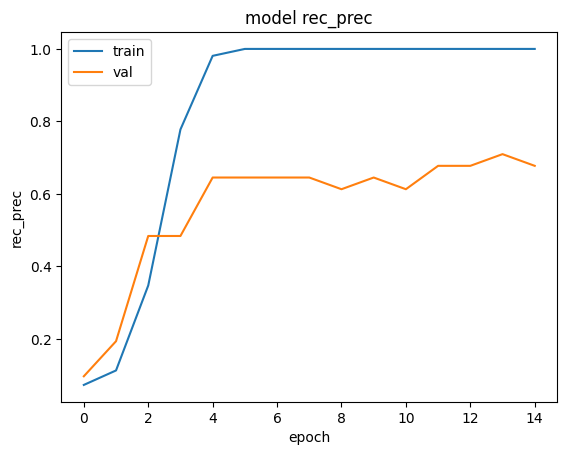

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
                   precision    recall  f1-score   support

            Спорт       1.00      1.00      1.00         2
      Бывший СССР       1.00      0.33      0.50         3
              Дом       0.67      1.00      0.80         2
         Культура       1.00      0.33      0.50         3
         Из жизни       0.67      0.67      0.67         3
         Ценности       0.67      1.00      0.80         2
Силовые структуры       1.00      0.50      0.67         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.33      1.00      0.50         1
          Легпром       0.50      1.00      0.67         1
  Наука и техника       1.00      0.67      0.80         3
             Крым       0.00      0.00      0.00         0
   69-я параллель       1.00      1.00      1.00         1
        Экономика       0.67      1.00      0.80         2
           Россия       0.33      0.50      0.40         2
           Бизне

### Задание 2 (5 баллов).

Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/gpt/gpt.ipynb

Попробуйте дообучать GPT на каком-то другом тексте (можете попробовать любые стихи или какие-то специфичные вещи вроде анекдотов или репа).
Попробуйте разные методы и параметры генерации (beam search, температура, top_k и тп). Сохраните в тетрадке несколько хороших сгенерированных текстов.

Можете использовать другую модель.


### Решил спарсить тексты группы Король и шут :)

In [ ]:
import requests as r
import re
from bs4 import BeautifulSoup as bs

response = r.get('https://slushat-tekst-pesni.ru/korol-i-shut/')

html_content = response.content
soup = bs(html_content, 'html.parser')
titles = soup.find_all('a')
titles = ['https://slushat-tekst-pesni.ru/korol-i-shut/' + i.replace('/korol-i-shut/', '').replace('">', '') for i in re.findall(r'/korol-i-shut/.*?">', str(titles))]


texts = []
for text in titles:
  try:
    print(text)
    response_titles = r.get(text)
    html_content_titles = response_titles.content
    soup = bs(html_content_titles, 'html.parser')
    text = soup.find_all('div', class_='abp')
    clean_text = str(text[0]).replace('<div class="abp">', '').replace('<br/>', '').replace('</div>', '')
    texts.append(clean_text)
  except Exception as e:
    print(e)

https://slushat-tekst-pesni.ru/korol-i-shut/ten-15-trinadcataya-rana
https://slushat-tekst-pesni.ru/korol-i-shut/vihozhu-iz-tmi
https://slushat-tekst-pesni.ru/korol-i-shut/esenin
https://slushat-tekst-pesni.ru/korol-i-shut/mertvii-anarhist
https://slushat-tekst-pesni.ru/korol-i-shut/bessonnica
https://slushat-tekst-pesni.ru/korol-i-shut/lesnik
https://slushat-tekst-pesni.ru/korol-i-shut/hardkor-po-russki
https://slushat-tekst-pesni.ru/korol-i-shut/ispoved-vampira
https://slushat-tekst-pesni.ru/korol-i-shut/vospominanie-o-biloi-lyubvi
https://slushat-tekst-pesni.ru/korol-i-shut/severnii-flot
https://slushat-tekst-pesni.ru/korol-i-shut/korol-i-shut
https://slushat-tekst-pesni.ru/korol-i-shut/nekromant
https://slushat-tekst-pesni.ru/korol-i-shut/vdova-i-gorbun
https://slushat-tekst-pesni.ru/korol-i-shut/a-m-t-v
https://slushat-tekst-pesni.ru/korol-i-shut/audiotrack-10
https://slushat-tekst-pesni.ru/korol-i-shut/arbuznaya-korka
https://slushat-tekst-pesni.ru/korol-i-shut/hevesta-palacha
ht

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
DEVICE = torch.device("cuda:0")

# Загружаем модель ruGPT от сбера
model_name_or_path = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path, use_cache=False).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
texts = [(num, text.replace('\r', '')) for num, text in enumerate(texts[:295])]

cleans = []
for num, text in texts:
  remove = [287, 243, 219, 197, 183, 161, 117, 98, 27, 17, 0]

  if num not in remove:
    cleans.append(text)

cleans

['Пролетели дни фокусы мои страх вели на всехОбрели успехИ не мало лет свой храня секретромантичный я предложил сюжетЧто ж, фокусы - ложь,Взрослые знают умы.Все же для нихТайны мои необъяснимы.Просят они: "Нас обмани,Чудо хотим видеть мы",Выхожу из тьмы!Но в один моментУжаснулся светМир узнал потом,Что подвоха нет.Что ж, фокусы - ложь,Взрослые знают умы.Все же для нихТайны мои необъяснимы.Просят они: "Нас обмани,Чудо хотим видеть мы",Выхожу из тьмы!',
 'Пой же, пой на проклятой гитаре,Мой последний, единственный друг.Захлебнуться бы в этом угаре,Пальцы пляшут твои в полукруг.Я не знал, что любовь - заразаЯ не знал, что любовь - чума.Подошла и прищуренным глазомХулигана свела с ума.Пой, мой друг, напевай мне сноваНашу прежнюю буйную рань.Пусть целует она другого,Молодая, красивая дрянь.Не гляди на ее запястьяИ с плечей ее льющийся шелк.Я искал в этой женщине счастья,А нечаянно гибель нашел.Так чего ж мне ее ревновать,Так чего ж мне болеть такому?Наша жизнь - простыня да кровать,Наша жиз

In [4]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Сохраним обучающие данные в .txt файл
train_path = '/content/drive/MyDrive/train_dataset.txt'
# with open(train_path, "w") as f:
#     f.write(' '.join(cleans))

In [5]:
# Создание датасета
train_dataset = TextDataset( tokenizer=tokenizer,file_path=train_path,block_size=64,
                            overwrite_cache=True)

# специальный класс который будет подавать в модель данные в нужном ей виде
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [6]:
from transformers import Trainer, TrainingArguments
import accelerate

training_args = TrainingArguments(
    output_dir= "./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=16,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (torch.optim.AdamW(model.parameters(),lr=1e-5),None) # Optimizer and lr scheduler
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [7]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=200, training_loss=3.597159423828125, metrics={'train_runtime': 1650.6521, 'train_samples_per_second': 65.55, 'train_steps_per_second': 0.121, 'total_flos': 3326116921344000.0, 'train_loss': 3.597159423828125, 'epoch': 94.12})

In [9]:
text = "За столом сидели"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        temperature=0.8,
                        top_k=50,
                        max_length=300,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


За столом сидели мы, и старуха была очень грустная, И, как всегда, мне приписывала свой взгляд. Я, конечно, не знал, что она не в себе, И, конечно, мне стало стыдно, Но как всегда, старуха все-таки сказала, Что не может быть, чтобы не была на свадьбе такой красивой! С тех пор прошло много лет, А я все не могу понять, Что ж за наважденье такая?! Старуха вдруг сказала: Да это же я, я - ведьма! И я не могла ее понять, И, конечно, ей стало стыдно, И, конечно, ей стало стыдно! И я ни слова не сказал, И, наверное, никогда больше не буду, Если со мной что-нибудь случится, То я тебя, моя ведьма, очень сильно обижу! И, конечно, я в ответ на это ничего не ответил, Я, конечно, сам виноват, но все же, мне стыдно! И, конечно, я не стал ее слушать, Я все пытался ее рассмешить, Но она меня не слышала и заплакала. И, конечно, я не стал ее слушать, Я все пытался ее рассмешить, Но она меня не слышала и заплакала. И, конечно, я не стал ее слушать, Я все пытался ее рассмешить, Но она меня не слышала и за

In [10]:
text = "С головы сорвал"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=5, top_k=100,
                        max_length=300,
                        repetition_penalty=3.5,
                        no_repeat_ngram_size=2,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


С головы сорвал капюшон,Выхватил из ножен меч.Крикнул стражникам: "Убирайтесь к чертям собачьим!"И растворился в воздухе.Мертвецов с собой не утащил!Но как-то странно на душе стало -Трупы по лесу бродят, мертвецы воют...Зловещим голосом ветер вещал:"Предательски опасен этот лес! В нем нет места для меня! Злобы я от него больше не испытываю! Не хочу жить среди мертвецов и слышать о том, что здесь твориться!".Вдруг раздался страшный крик со стороны леса.Лес содрогнулся, словно под ним разверзлась пропасть.Там, где раньше был овраг,Теперь зияет глубокая яма.Откуда она взялась?Что за дьявольщина?! Что за наважденье?!"Проклятая луна над головой нависла,Ужасный холод пробирает до костей."Разбежавшись, прыгну со скалы вниз,А там уж точно найду покойника!"Не веря своим глазам, парень полетел вниз.Чудовищную находку он увидал,Спустившись с крутого склона.Перед ним лежала мертвецкая голова.Из раны торчал длинный обломок шпаги.Обречённо парень застыл у трупа.На губах застыло кровавое месиво.Бедн

In [13]:
text = "В провинциальном городке"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=5, top_k=50,
                        max_length=300,
                        repetition_penalty=1.5,
                        no_repeat_ngram_size=2,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


В провинциальном городке,Где все друг друга знают,Есть парень по имени Джек.Он всю жизнь с ружьем в одной руке,А в другой - шпага. И вот однажды он повстречал своего старого друга.Здравствуй, старый друг, я не знал, что ты здесь.Я очень скучал по тебе,Джек, и до сих пор не понимаю,Как же мне тебя не хватало!Я так устал от твоих звонков,Своих дурацких шуточек,И от твоей глупой болтовни.Прости, дружище, но я больше не могу жить без тебя.Вот такая вот грустная история случилась со мной.И теперь я точно знаю,Что никогда не смогу забыть тот день,Когда увидел ты меня.Ты ведь был прав, когда говорил,что я похож на мертвеца.Но я все-таки верю в это.Ведь я всегда буду помнить о том,Кто я есть на самом деле.Знаю я одно - ты для меня не человек.Тебя я потерял, а значит, мне осталось совсем немного,Чтоб понять, как сильно я ошибался.Умерла моя подруга детства,Которая так сильно меня любила.Такая вот печальная история произошла со мною...Ох уж эти сентиментальные истории,Глупые они все, да глупы..